In [1]:
import numpy as np
import os
import glob
import random
import shutil
from shutil import move
from scipy.io import loadmat, savemat
from scipy.signal import convolve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout,LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from PyEMD import EMD
import pandas as pd
from scipy.stats import median_abs_deviation
from scipy.io import loadmat
from tqdm import tqdm

Partie Pré-processing

In [22]:
# Move the matrix

source_dir = r"C:\Users\ocler\Documents\Académique\Inner_speech\data"
target_dir = r"C:\Users\ocler\Documents\Académique\Inner_speech\epoched_mat"

if not os.path.exists(target_dir):
    os.makedirs(target_dir)

# Walk through the source directory
for root, dirs, files in os.walk(source_dir):
    for file in files:
        # Check if the file name contains 'epoched' and does not contain 'rejection'
        if 'epoched' in file:

            file_path = os.path.join(root, file)
            target_file_path = os.path.join(target_dir, file)

            shutil.move(file_path, target_file_path)
            print(f"Moved: {file_path} to {target_file_path}")

print("Moving complete.")

Moved: C:\Users\ocler\Documents\Académique\Inner_speech\data\OC01\OC01_emg_epoched_rejection.mat to C:\Users\ocler\Documents\Académique\Inner_speech\epoched_mat\OC01_emg_epoched_rejection.mat
Moved: C:\Users\ocler\Documents\Académique\Inner_speech\data\OC02\OC02_emg_epoched_rejection.mat to C:\Users\ocler\Documents\Académique\Inner_speech\epoched_mat\OC02_emg_epoched_rejection.mat
Moved: C:\Users\ocler\Documents\Académique\Inner_speech\data\OC03\OC03_emg_epoched_rejection.mat to C:\Users\ocler\Documents\Académique\Inner_speech\epoched_mat\OC03_emg_epoched_rejection.mat
Moved: C:\Users\ocler\Documents\Académique\Inner_speech\data\OC04\OC04_emg_epoched_rejection.mat to C:\Users\ocler\Documents\Académique\Inner_speech\epoched_mat\OC04_emg_epoched_rejection.mat
Moved: C:\Users\ocler\Documents\Académique\Inner_speech\data\OC05\OC05_emg_epoched_rejection.mat to C:\Users\ocler\Documents\Académique\Inner_speech\epoched_mat\OC05_emg_epoched_rejection.mat
Moved: C:\Users\ocler\Documents\Académiq

In [3]:
# Check the structure of the Matrixs

mat_data = loadmat(r"C:\Users\ocler\Documents\Académique\Inner_speech\epoched_mat\OC21_emg_epoched.mat", simplify_cells=True)

# Access the 'preprocessing' structure
preprocessing = mat_data['preprocessing']

# Check if 'preprocessing' is a dictionary (common when loading MATLAB structures)
if isinstance(preprocessing, dict):
    # Iterate over each key-value pair in the dictionary
    for key, value in preprocessing.items():
        print(f"Key: {key}")
        if isinstance(value, np.ndarray):
            print(f"  Value type: {type(value)}, shape: {value.shape}")
        else:
            print(f"  Value type: {type(value)}")
else:
    print("preprocessing is not a dictionary.")


Key: samplingfreq_emg
  Value type: <class 'int'>
Key: samplingfreq_wav
  Value type: <class 'int'>
Key: channels
  Value type: <class 'numpy.ndarray'>, shape: (5,)
Key: triggers
  Value type: <class 'numpy.ndarray'>, shape: (5,)
Key: trials_trigger_values
  Value type: <class 'numpy.ndarray'>, shape: (133,)
Key: trials
  Value type: <class 'list'>
Key: trialDataMatrix
  Value type: <class 'numpy.ndarray'>, shape: (144, 5000, 5)
Key: trialWav
  Value type: <class 'numpy.ndarray'>, shape: (144, 10000)
Key: triggerCondition
  Value type: <class 'numpy.ndarray'>, shape: (5,)
Key: trialCondition
  Value type: <class 'numpy.ndarray'>, shape: (133,)
Key: conditionLabels
  Value type: <class 'numpy.ndarray'>, shape: (5,)
Key: epochCondition
  Value type: <class 'dict'>
Key: logOS_cellarray
  Value type: <class 'numpy.ndarray'>, shape: (144, 2)


In [12]:
# Extracte all trials to the trials folder (except rejected trials)

def extract_and_save_trials(original_mat_file, trials_dir, rejection_mat_file):
    # Extract the subject number from the original file name
    subject_number = os.path.basename(original_mat_file).split('_')[0]
    # Load the .mat file with the trial data
    mat_data = loadmat(original_mat_file, simplify_cells=True)
    # Load the .mat file with the rejection information
    rejection_data = loadmat(rejection_mat_file, simplify_cells=True)
    
    # Access the 'preprocessing' structure for trials data
    preprocessing = mat_data['preprocessing']
    # Access the 'art_rejection' structure for rejection data
    art_rejection = rejection_data['art_rejection']

    # Extracting trials and their conditions
    trials_info = preprocessing['trials']
    trial_data_matrix = preprocessing['trialDataMatrix']
    channels = preprocessing['channels']
    rejection_info = art_rejection['reject_trial']

    # Saving each non-rejected trial as a .mat file
    for trial_idx, (trial_info, is_rejected) in enumerate(zip(trials_info, rejection_info)):
        if not is_rejected:
            if isinstance(trial_info, dict) and 'factors' in trial_info:
                condition = trial_info['factors'][-1]
                for channel_idx, channel in enumerate(channels):
                    trial_data = trial_data_matrix[trial_idx, :, channel_idx]
                    trial_name = f"{subject_number}_Trial{trial_idx + 1}_{condition}_{channel}"

                    # Dictionary to save as .mat file
                    data_to_save = {'data': trial_data}

                    # Construct file path
                    file_path = os.path.join(trials_dir, f"{trial_name}.mat")

                    # Save the .mat file
                    savemat(file_path, data_to_save)

    print(f"Trial data extraction for {subject_number} completed.")


# Define the source directory where the .mat files are located
source_dir = r"C:\Users\ocler\Documents\Académique\Inner_speech\epoched_mat"

# Define the 'Trials' directory
trials_dir = os.path.join(source_dir, "Trials")

# Create the 'Trials' directory if it doesn't exist
if not os.path.exists(trials_dir):
    os.makedirs(trials_dir)

# Process all .mat files in the source directory
for file_name in os.listdir(source_dir):
    if file_name.endswith('_epoched.mat'):
        # Construct the full paths for the current .mat files
        original_mat_file = os.path.join(source_dir, file_name)
        rejection_mat_file = original_mat_file.replace('_epoched.mat', '_epoched_rejection.mat')

        # Check if the rejection file exists
        if os.path.exists(rejection_mat_file):
            # Call the function to extract and save trials for this file
            extract_and_save_trials(original_mat_file, trials_dir, rejection_mat_file)
        else:
            print(f"Rejection file does not exist for {file_name}")

print("All .mat files processed.")

Trial data extraction for OC01 completed.
Trial data extraction for OC02 completed.
Trial data extraction for OC03 completed.
Trial data extraction for OC04 completed.
Trial data extraction for OC05 completed.
Trial data extraction for OC06 completed.
Trial data extraction for OC07 completed.
Trial data extraction for OC09 completed.
Trial data extraction for OC10 completed.
Trial data extraction for OC11 completed.
Trial data extraction for OC12 completed.
Trial data extraction for OC13 completed.
Trial data extraction for OC15 completed.
Trial data extraction for OC16 completed.
Trial data extraction for OC17 completed.
Trial data extraction for OC18 completed.
Trial data extraction for OC19 completed.
Trial data extraction for OC20 completed.
Trial data extraction for OC21 completed.
Trial data extraction for OC22 completed.
Trial data extraction for OC23 completed.
Trial data extraction for OC24 completed.
Trial data extraction for OC25 completed.
Trial data extraction for OC26 com

In [13]:
# Organize the trials by condition and channel

# Mapping of old condition codes to new folder names
condition_mapping = {
    'deb_V': 'mental_visualization',
    'deb_IS': 'inner_speech',
    'deb_OS': 'overt_speech',
    'Bip': 'mind_wandering',
    'relax': 'control_baseline'
}

# List of channel names
channels = ['for', 'fro', 'nek', 'chn', 'ooi', 'zyg']

# Loop through each file in the trials directory
for file_name in os.listdir(trials_dir):
    if file_name.endswith('.mat'):
        # Determine the new condition folder and channel based on the file name
        for old_condition, new_condition in condition_mapping.items():
            if old_condition in file_name:
                condition_folder = os.path.join(trials_dir, new_condition)
                break
        else:
            print(f"No condition found in file name: {file_name}")
            continue

        for channel in channels:
            if f"_{channel}" in file_name:
                channel_folder = os.path.join(condition_folder, channel)
                break
        else:
            print(f"No channel found in file name: {file_name}")
            continue

        # Create the condition and channel folders if they don't exist
        os.makedirs(channel_folder, exist_ok=True)

        # Move the file to the appropriate channel subfolder within the condition folder
        src_file_path = os.path.join(trials_dir, file_name)
        dest_file_path = os.path.join(channel_folder, file_name)
        shutil.move(src_file_path, dest_file_path)
        print(f"Moved {file_name} to {dest_file_path}")

print("Reorganization completed.")


Moved OC01_Trial102_deb_IS_chn.mat to C:\Users\ocler\Documents\Académique\Inner_speech\epoched_mat\Trials\inner_speech\chn\OC01_Trial102_deb_IS_chn.mat
Moved OC01_Trial102_deb_IS_for.mat to C:\Users\ocler\Documents\Académique\Inner_speech\epoched_mat\Trials\inner_speech\for\OC01_Trial102_deb_IS_for.mat
Moved OC01_Trial102_deb_IS_fro.mat to C:\Users\ocler\Documents\Académique\Inner_speech\epoched_mat\Trials\inner_speech\fro\OC01_Trial102_deb_IS_fro.mat
Moved OC01_Trial102_deb_IS_nek.mat to C:\Users\ocler\Documents\Académique\Inner_speech\epoched_mat\Trials\inner_speech\nek\OC01_Trial102_deb_IS_nek.mat
Moved OC01_Trial102_deb_IS_ooi.mat to C:\Users\ocler\Documents\Académique\Inner_speech\epoched_mat\Trials\inner_speech\ooi\OC01_Trial102_deb_IS_ooi.mat
Moved OC01_Trial102_deb_IS_zyg.mat to C:\Users\ocler\Documents\Académique\Inner_speech\epoched_mat\Trials\inner_speech\zyg\OC01_Trial102_deb_IS_zyg.mat
Moved OC01_Trial105_deb_IS_chn.mat to C:\Users\ocler\Documents\Académique\Inner_speech\e

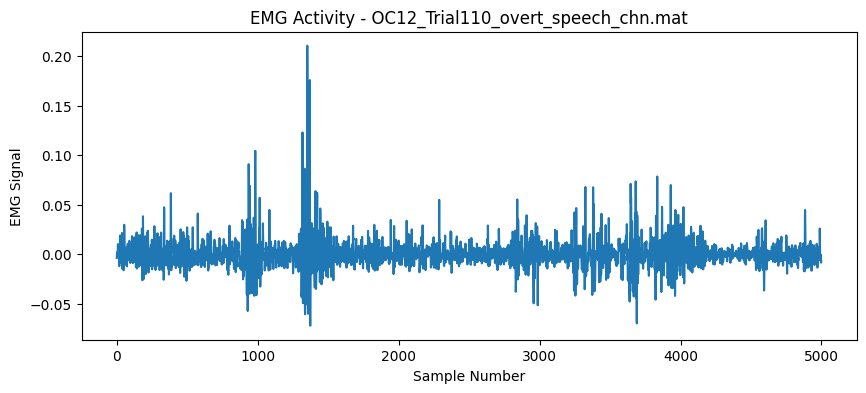

In [15]:
# Plot a random trial

# Define the source directory where the .mat files are located
source_dir = r"C:\Users\ocler\Documents\Académique\Inner_speech\epoched_mat"

# Define the 'Trials' directory
trials_dir = os.path.join(source_dir, "Trials")
# Get a list of all condition folders in the 'Trials' directory
condition_folders = [os.path.join(trials_dir, f) for f in os.listdir(trials_dir)
                     if os.path.isdir(os.path.join(trials_dir, f))]

# Randomly select one condition folder
random_condition_folder = random.choice(condition_folders)

# Get a list of all channel folders in the randomly selected condition folder
channel_folders = [os.path.join(random_condition_folder, f) for f in os.listdir(random_condition_folder)
                   if os.path.isdir(os.path.join(random_condition_folder, f))]

# Randomly select one channel folder
random_channel_folder = random.choice(channel_folders)

# Get a list of all .mat files in the randomly selected channel folder
mat_files = [f for f in os.listdir(random_channel_folder) if f.endswith('.mat')]

# Randomly select one .mat file
random_mat_file = random.choice(mat_files)

# Construct the full file path for the randomly selected .mat file
random_file_path = os.path.join(random_channel_folder, random_mat_file)

# Load the .mat file
mat_contents = loadmat(random_file_path)

# Assume the variable in .mat is 'data', extract it
emg_data = mat_contents['data'].flatten()  # Flatten in case it's 2D

# Plot the data with the file name as the title
plt.figure(figsize=(10, 4))
plt.plot(emg_data)
plt.title(f'EMG Activity - {random_mat_file}')
plt.xlabel('Sample Number')
plt.ylabel('EMG Signal')
plt.show()

In [20]:
# Rename the conditions

# Define paths and parameters
trials_dir = "C:/Users/ocler/Documents/Académique/Inner_speech/epoched_mat/Trials"
conditions = ['control_baseline', 'mind_wandering', 'inner_speech', 'overt_speech', 'mental_visualization']
channels = ['ooi', 'nek', 'zyg', 'for', 'fro', 'chn']

# Define the mapping of original substrings to new substrings
rename_mapping = {
    'deb_OS': 'overt_speech',
    'deb_IS': 'inner_speech',
    'deb_V': 'mental_visualization',
    'Bip': 'mind_wandering',
    'relax': 'control_baseline'
}

# Function to rename files based on mapping
def rename_files_in_directory(directory, mapping):
    for root, dirs, files in os.walk(directory):
        for filename in files:
            new_name = filename
            for old_substring, new_substring in mapping.items():
                new_name = new_name.replace(old_substring, new_substring)
            if new_name != filename:
                old_file = os.path.join(root, filename)
                new_file = os.path.join(root, new_name)
                os.rename(old_file, new_file)

# Iterate over each condition and channel directory
for condition in conditions:
    for channel in channels:
        channel_dir = os.path.join(trials_dir, condition, channel)
        if os.path.exists(channel_dir):
            rename_files_in_directory(channel_dir, rename_mapping)

print("Files have been renamed in all condition and channel directories.")


Files have been renamed in all condition and channel directories.


In [32]:
# Check if some trials are in one channel but not another

# Define the base directory for trials
trials_dir = "C:/Users/ocler/Documents/Académique/Inner_speech/epoched_mat/Trials"

# Function to compare trials between two channels within a given condition
def compare_trials_in_channels(condition, channel1, channel2):
    # Construct the paths to the channel directories
    channel1_dir = os.path.join(trials_dir, condition, channel1)
    channel2_dir = os.path.join(trials_dir, condition, channel2)

    # Get the list of trial names in each channel directory, stripping the channel part and extension
    trials_channel1 = {os.path.splitext(f)[0][:-len(channel1)] for f in os.listdir(channel1_dir) if f.endswith('.mat')}
    trials_channel2 = {os.path.splitext(f)[0][:-len(channel2)] for f in os.listdir(channel2_dir) if f.endswith('.mat')}

    # Find trials unique to each channel
    unique_to_channel1 = trials_channel1 - trials_channel2
    unique_to_channel2 = trials_channel2 - trials_channel1

    # Print the results
    if unique_to_channel1:
        print(f"Trials in '{channel1}' not in '{channel2}':")
        for trial in unique_to_channel1:
            print(trial + channel1 + '.mat')
    else:
        print(f"All trials in '{channel1}' are also in '{channel2}'.")

    if unique_to_channel2:
        print(f"Trials in '{channel2}' not in '{channel1}':")
        for trial in unique_to_channel2:
            print(trial + channel2 + '.mat')
    else:
        print(f"All trials in '{channel2}' are also in '{channel1}'.")


compare_trials_in_channels('control_baseline', 'ooi', 'zyg')
compare_trials_in_channels('overt_speech', 'ooi', 'nek')
compare_trials_in_channels('control_baseline', 'ooi', 'zyg')
compare_trials_in_channels('overt_speech', 'ooi', 'nek')
compare_trials_in_channels('control_baseline', 'ooi', 'zyg')
compare_trials_in_channels('overt_speech', 'ooi', 'nek')


All trials in 'ooi' are also in 'zyg'.
All trials in 'zyg' are also in 'ooi'.
All trials in 'ooi' are also in 'nek'.
All trials in 'nek' are also in 'ooi'.


In [23]:
# Copy trials to trials for models but remove chn (sensor gave up during session)


# Define paths and parameters
trials_dir = "C:/Users/ocler/Documents/Académique/Inner_speech/epoched_mat/Trials"
dest_dir = "C:/Users/ocler/Documents/Académique/Inner_speech/Classif_EMG"
conditions = ['control_baseline', 'mind_wandering', 'inner_speech', 'overt_speech', 'mental_visualization']
channels = ['ooi', 'nek', 'zyg', 'for', 'fro']

# Function to find common trials across channels
def find_common_trials(condition_path, channels):
    common_trials = None
    for channel in channels:
        channel_trials = set()
        channel_path = os.path.join(condition_path, channel)
        if os.path.exists(channel_path):
            for f in glob(os.path.join(channel_path, '*.mat')):
                trial_name = '_'.join(os.path.basename(f).split('_')[:-1])
                channel_trials.add(trial_name)
            if common_trials is None:
                common_trials = channel_trials
            else:
                common_trials &= channel_trials
    return list(common_trials) if common_trials else []

trials_for_models_dir = os.path.join(dest_dir, "trials_for_models")
os.makedirs(trials_for_models_dir, exist_ok=True)

for condition in conditions:
    condition_path = os.path.join(trials_dir, condition)
    common_trials = find_common_trials(condition_path, channels)

    if common_trials:
        for trial in common_trials:
            for channel in channels:
                file_pattern = f"{trial}_{channel}.mat"
                file_path = glob(os.path.join(condition_path, channel, file_pattern))
                if file_path:
                    shutil.copy(file_path[0], os.path.join(trials_for_models_dir, os.path.basename(file_path[0])))

In [27]:
# Compare Trials folder and trials_for_model


# Define paths
trials_dir = "C:/Users/ocler/Documents/Académique/Inner_speech/epoched_mat/Trials"
dest_dir = "C:/Users/ocler/Documents/Académique/Inner_speech/Classif_EMG"

# Function to get the set of trial names from a directory, excluding those with 'chn'
def get_trials_from_dir(directory, exclude='chn'):
    trials = set()
    for f in glob.glob(os.path.join(directory, '**', '*.mat'), recursive=True):
        trial_name = os.path.splitext(os.path.basename(f))[0]
        if exclude not in trial_name:
            trials.add(trial_name)
    return trials

# Function to find missing trials and print totals
def find_missing_trials_and_print_totals(trials_dir, dest_dir):
    # Get all trials from the original trials directory
    old_trials = get_trials_from_dir(trials_dir)
    print(f"Total trials in original folder (excluding 'chn'): {len(old_trials)}")

    # Get all trials from the destination directory
    new_trials = get_trials_from_dir(dest_dir)
    print(f"Total trials in new folder: {len(new_trials)}")

    # Identify missing trials
    missing_trials = old_trials - new_trials

    # Optionally, print missing trials
    if missing_trials:
        print("Trials in the original folder but not in trials_for_model:")
        for trial in missing_trials:
            print(trial)
    else:
        print("No missing trials detected.")

# Execute the function
find_missing_trials_and_print_totals(trials_dir, dest_dir)

Total trials in original folder (excluding 'chn'): 19045
Total trials in new folder: 19045
No missing trials detected.


In [30]:
# Create a df with the raw data (19045 *5000 df)

def load_data(trials_dir):
    all_data = []
    column_names = ['subject', 'trial', 'condition', 'channel']

    all_files = os.listdir(trials_dir)
    
    for file_name in tqdm(all_files, desc="Loading data"):
        if file_name.endswith('.mat'):
            # Extract metadata from file name
            parts = file_name.split('_')
            subject = parts[0]
            trial = parts[1]
            condition = "_".join(parts[2:-1])  # Join all parts except the last one as condition
            channel = parts[-1].split('.')[0]

            # Load data from .mat file
            mat_contents = loadmat(os.path.join(trials_dir, file_name))
            data = mat_contents['data'].flatten()  # Flatten in case it's not 1D

            # Append metadata and data to the list
            all_data.append([subject, trial, condition, channel] + data.tolist())

    # Create additional column names for the data points
    data_points_columns = ['data_point_{}'.format(i+1) for i in range(len(all_data[0]) - 4)]
    
    # Combine the column names
    column_names += data_points_columns

    # Create a DataFrame with all data
    df_all_data = pd.DataFrame(all_data, columns=column_names)
    
    return df_all_data

def save_data(df, output_dir, file_name='raw_data.csv'):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    output_path = os.path.join(output_dir, file_name)
    df.to_csv(output_path, index=False)
    print(f"Data saved to {output_path}")

# Example usage
trials_dir = "C:/Users/ocler/Documents/Académique/Inner_speech/Classif_EMG/trials_for_models"
df = load_data(trials_dir)

# Specify the directory where you want to save the CSV
dest_dir = "C:/Users/ocler/Documents/Académique/Inner_speech/Classif_EMG/csv"
save_data(df, dest_dir)

Loading data: 100%|██████████| 19045/19045 [00:18<00:00, 1038.67it/s]


Data saved to C:/Users/ocler/Documents/Académique/Inner_speech/Classif_EMG/csv\raw_data.csv


In [31]:
# Get the dimensions of the raw DataFrame

df = pd.read_csv('C:/Users/ocler/Documents/Académique/Inner_speech/Classif_EMG/csv/raw_data.csv')
print(f"The DataFrame has {df.shape[0]} rows and {df.shape[1]} columns.")

# Check the data types of the columns
print(df.dtypes)

The DataFrame has 19045 rows and 5004 columns.
subject             object
trial               object
condition           object
channel             object
data_point_1       float64
                    ...   
data_point_4996    float64
data_point_4997    float64
data_point_4998    float64
data_point_4999    float64
data_point_5000    float64
Length: 5004, dtype: object


In [ ]:
# Compute features
# (1) Make the same transformation as ladislas 
# centered and rectified data

def center_and_rectify(df_in_path, df_out_path):
    # Load the EMG data from a CSV file
    df = pd.read_csv(df_in_path)

    data_columns = [col for col in df.columns if col.startswith('data_point')]

    # Center and rectify the EMG signal for each trial
    # Subtract the mean of each trial and take the absolute value
    df[data_columns] = df[data_columns].apply(lambda x: np.abs(x - x.mean()), axis=1)

    df.to_csv(df_out_path, index=False)

input_csv = 'C:/Users/ocler/Documents/Académique/Inner_speech/Classif_EMG/csv/raw_data.csv'
output_csv_file = 'C:/Users/ocler/Documents/Académique/Inner_speech/Classif_EMG/csv/centered_rectified_data.csv'

center_and_rectify(input_csv, output_csv_file)

# test en corrigeant par la baseline puis en computant les metrics

def process_emg_data(df_in_path, df_out_path):
    # Load the centered and rectified data
    df = pd.read_csv(df_in_path)

    # Identify data columns

    data_columns = [c for c in df.columns if c.startswith('data_point')]
    # --- compute baseline mean/std from ALL baseline data points ---
    baseline = df[df['condition'] == 'control_baseline']

    def flatten_stats(group):
        vals = group[data_columns].to_numpy().ravel()
        mean = vals.mean()
        std = vals.std(ddof=0)  # ddof=0 to match population std unless you prefer ddof=1
        if std == 0 or np.isnan(std):
            std = 1e-8  # avoid divide-by-zero; you may also flag these channels
        return pd.Series({'baseline_mean': mean, 'baseline_std': std})

    baseline_stats = (
        baseline.groupby(['subject', 'channel'])
                .apply(flatten_stats)
                .reset_index()
    )

    df = df.merge(baseline_stats, on=['subject', 'channel'], how='left')

    # z-score each data point using those baseline stats
    z_scored_data = (df[data_columns].sub(df['baseline_mean'], axis=0))\
                                .div(df['baseline_std'], axis=0)
    z_scored_data.columns = [f'z_score_{c}' for c in data_columns]

    # then compute per-trial features from z_scored_data
    metrics_df = pd.DataFrame({
        'z_score': z_scored_data.mean(axis=1),
        'std':     z_scored_data.std(axis=1),
        'median':  z_scored_data.median(axis=1),
        'mad':     z_scored_data.apply(lambda x: median_abs_deviation(x), axis=1),
        'iqr':     z_scored_data.apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25), axis=1),
    })

    # Combine the original df with the computed metrics
    result_df = pd.concat([df[['subject', 'trial', 'condition', 'channel']], metrics_df], axis=1)

    # Specify the columns to keep in the final DataFrame, renaming where needed
    columns_to_keep = ['subject', 'trial', 'condition', 'channel', 'z_score', 'std', 'median', 'mad', 'iqr']
    result_df = result_df[columns_to_keep]
    result_df.to_csv(df_out_path, index=False)

input_csv = 'C:/Users/ocler/Documents/Académique/Inner_speech/Classif_EMG/csv/centered_rectified_data.csv'
output_csv_file = 'C:/Users/ocler/Documents/Académique/Inner_speech/Classif_EMG/csv/features_z.csv'

process_emg_data(input_csv, output_csv_file)

In [ ]:
# # (1) Make the same transformation as ladislas 
# # centered and rectified data

# def center_and_rectify(df_in_path, df_out_path):
#     # Load the EMG data from a CSV file
#     df = pd.read_csv(df_in_path)

#     data_columns = [col for col in df.columns if col.startswith('data_point')]

#     # Center and rectify the EMG signal for each trial
#     # Subtract the mean of each trial and take the absolute value
#     df[data_columns] = df[data_columns].apply(lambda x: np.abs(x - x.mean()), axis=1)

#     df.to_csv(df_out_path, index=False)

# input_csv = 'C:/Users/ocler/Documents/Académique/Inner_speech/Classif_EMG/csv/raw_data.csv'
# output_csv_file = 'C:/Users/ocler/Documents/Académique/Inner_speech/Classif_EMG/csv/centered_rectified_data.csv'

# center_and_rectify(input_csv, output_csv_file)


In [41]:
# Get the dimensions of the transformed DataFrame

df = pd.read_csv('C:/Users/ocler/Documents/Académique/Inner_speech/Classif_EMG/csv/centered_rectified_data.csv')

# Get the dimensions of the DataFrame
print(f"The DataFrame has {df.shape[0]} rows and {df.shape[1]} columns.")

# Check the data types of the columns
print(df.dtypes)

The DataFrame has 19045 rows and 5008 columns.
subject               object
trial                 object
condition             object
channel               object
data_point_1         float64
                      ...   
data_point_5000      float64
average_amplitude    float64
baseline_mean        float64
baseline_std         float64
delta                float64
Length: 5008, dtype: object


In [ ]:
# # (2) Make the same transformation as ladislas and compute the same features as ladislas ((centered-rectified mean), z-score, median, sd, mad, idr)
# # mean - mean baseline / sd baseline
# # compute features

# def process_emg_data(df_in_path, df_out_path):
#     # Load the centered and rectified data
#     df = pd.read_csv(df_in_path)

#     # Identify data columns
#     data_columns = [col for col in df.columns if col.startswith('data_point')]

#     # Compute the average amplitude for each trial
#     df['centered_rectified_mean'] = df[data_columns].mean(axis=1)
#     df['std'] = df[data_columns].std(axis=1)
#     df['median'] = df[data_columns].median(axis=1)
#     df['mad'] = df[data_columns].apply(lambda x: median_abs_deviation(x), axis=1)
#     df['iqr'] = df[data_columns].apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25), axis=1)

#     # Normalize and standardize based on baseline condition
#     baseline_stats = df[df['condition'] == 'control_baseline'].groupby(['subject', 'channel']).agg({
#         'centered_rectified_mean': ['mean', 'std']
#     })
#     baseline_stats.columns = ['baseline_mean', 'baseline_std']
#     baseline_stats.reset_index(inplace=True)

#     # Merge baseline stats back to the original DataFrame
#     df = df.merge(baseline_stats, on=['subject', 'channel'], how='left')

#     # Calculate z-score
#     df['z_score'] = (df['centered_rectified_mean'] - df['baseline_mean']) / df['baseline_std']

#     # Specify the columns to keep in the final DataFrame, renaming where needed
#     columns_to_keep = ['subject', 'trial', 'condition', 'channel', 'centered_rectified_mean', 'z_score', 'std', 'median', 'mad', 'iqr']
#     df = df[columns_to_keep]
#     df.to_csv(df_out_path, index=False)

# input_csv = 'C:/Users/ocler/Documents/Académique/Inner_speech/Classif_EMG/csv/centered_rectified_data.csv'
# output_csv_file = 'C:/Users/ocler/Documents/Académique/Inner_speech/Classif_EMG/csv/features.csv'

# process_emg_data(input_csv, output_csv_file)

In [ ]:
# # test en corrigeant par la baseline puis en computant les metrics

# def process_emg_data(df_in_path, df_out_path):
#     # Load the centered and rectified data
#     df = pd.read_csv(df_in_path)

#     # Identify data columns
#     data_columns = [col for col in df.columns if col.startswith('data_point')]

#     # Compute the average amplitude for each trial
#     df['centered_rectified_mean'] = df[data_columns].mean(axis=1)
#     df['std'] = df[data_columns].std(axis=1)
    
#     # Normalize and standardize based on baseline condition
#     baseline_stats = df[df['condition'] == 'control_baseline'].groupby(['subject', 'channel']).agg({
#         'centered_rectified_mean': ['mean', 'std']
#     })
#     baseline_stats.columns = ['baseline_mean', 'baseline_std']
#     baseline_stats.reset_index(inplace=True)

#     # Merge baseline stats back to the original DataFrame
#     df = df.merge(baseline_stats, on=['subject', 'channel'], how='left')

#     # Calculate z-score for each data point
#     z_scored_data = (df[data_columns].sub(df['baseline_mean'], axis=0)).div(df['baseline_std'], axis=0)
#     z_scored_data.columns = [f'z_score_{col}' for col in data_columns]

#     # Compute metrics on z-scored data points
#     metrics_df = pd.DataFrame()
#     metrics_df['z_score'] = z_scored_data.mean(axis=1)
#     metrics_df['std'] = z_scored_data.std(axis=1)
#     metrics_df['median'] = z_scored_data.median(axis=1)
#     metrics_df['mad'] = z_scored_data.apply(lambda x: median_abs_deviation(x), axis=1)
#     metrics_df['iqr'] = z_scored_data.apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25), axis=1)

#     # Combine the original df with the computed metrics
#     result_df = pd.concat([df[['subject', 'trial', 'condition', 'channel']], metrics_df], axis=1)

#     # Specify the columns to keep in the final DataFrame, renaming where needed
#     columns_to_keep = ['subject', 'trial', 'condition', 'channel', 'z_score', 'std', 'median', 'mad', 'iqr']
#     result_df = result_df[columns_to_keep]
#     result_df.to_csv(df_out_path, index=False)

# input_csv = 'C:/Users/ocler/Documents/Académique/Inner_speech/Classif_EMG/csv/centered_rectified_data.csv'
# output_csv_file = 'C:/Users/ocler/Documents/Académique/Inner_speech/Classif_EMG/csv/features_z.csv'

# process_emg_data(input_csv, output_csv_file)

In [22]:
def find_nan_rows(df):
    """
    This function identifies rows with NaN values in a DataFrame and returns the 'condition'
    and other relevant information for those rows.

    Parameters:
        df (pd.DataFrame): The DataFrame to be analyzed.

    Returns:
        pd.DataFrame: A DataFrame containing rows with NaN values, specifically showing the 'condition'
        and any other columns you choose to include.
    """
    # Create a mask where any row with a NaN is True
    nan_rows = df[df.isna().any(axis=1)]
    
    # Return the rows with NaNs, focusing on the 'condition' and potentially other columns
    return nan_rows[['condition', 'subject']]  # Add any other relevant columns to the list

# Usage example
nan_row_conditions = find_nan_rows(features_df)
print(nan_row_conditions)



             condition subject
8746    mind_wandering    OC20
8751    mind_wandering    OC20
8756    mind_wandering    OC20
8761      inner_speech    OC20
8766      inner_speech    OC20
...                ...     ...
9271    mind_wandering    OC20
9276    mind_wandering    OC20
9281    mind_wandering    OC20
9286    mind_wandering    OC20
9291  control_baseline    OC20

[110 rows x 2 columns]


In [ ]:
# # test avec une correction en enlevant la moyenne obtenue dans le channel for

# import pandas as pd
# import numpy as np
# from scipy.stats import median_abs_deviation

# def process_emg_data(df_in_path, df_out_path):
#     # Load the centered and rectified data
#     df = pd.read_csv(df_in_path)

#     # Identify data columns
#     data_columns = [col for col in df.columns if col.startswith('data_point')]

#     # Compute the average amplitude for each trial
#     df['centered_rectified_mean'] = df[data_columns].mean(axis=1)
#     df['std'] = df[data_columns].std(axis=1)
#     df['median'] = df[data_columns].median(axis=1)
#     df['mad'] = df[data_columns].apply(lambda x: median_abs_deviation(x), axis=1)
#     df['iqr'] = df[data_columns].apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25), axis=1)

#     # Compute the mean centered_rectified_mean by subject and condition for channel 'for'
#     correction_means = df[df['channel'] == 'for'].groupby(['subject', 'condition'])['centered_rectified_mean'].mean().reset_index()
#     correction_means.rename(columns={'centered_rectified_mean': 'correction_mean'}, inplace=True)

#     # Merge the correction means back to the original DataFrame
#     df = df.merge(correction_means, on=['subject', 'condition'], how='left')

#     # Subtract the correction mean from the centered_rectified_mean
#     df['centered_rectified_mean'] -= df['correction_mean']

#     # Drop the correction_mean column as it's no longer needed
#     df.drop(columns=['correction_mean'], inplace=True)

#     # Normalize and standardize based on baseline condition
#     baseline_stats = df[df['condition'] == 'control_baseline'].groupby(['subject', 'channel']).agg({
#         'centered_rectified_mean': ['mean', 'std']
#     })
#     baseline_stats.columns = ['baseline_mean', 'baseline_std']
#     baseline_stats.reset_index(inplace=True)

#     # Merge baseline stats back to the original DataFrame
#     df = df.merge(baseline_stats, on=['subject', 'channel'], how='left')

#     # Calculate z-score (z_score)
#     df['z_score'] = (df['centered_rectified_mean'] - df['baseline_mean']) / df['baseline_std']

#     # Specify the columns to keep in the final DataFrame, renaming where needed
#     columns_to_keep = ['subject', 'trial', 'condition', 'channel', 'centered_rectified_mean', 'z_score', 'std', 'median', 'mad', 'iqr']
#     df = df[columns_to_keep]
#     df.to_csv(df_out_path, index=False)

# # Specify file paths
# input_csv = 'C:/Users/ocler/Documents/Académique/Inner_speech/Classif_EMG/csv/centered_rectified_data.csv'
# output_csv_file = 'C:/Users/ocler/Documents/Académique/Inner_speech/Classif_EMG/csv/features_test_for.csv'

# # Process the data
# process_emg_data(input_csv, output_csv_file)


In [ ]:
# # create a shuffle model, within subject for mental condition only, respecting the number of trials by condition

# # Function to shuffle the conditions within each subject
# def shuffle_conditions(df):
#     shuffled_df = df.copy()
    
#     # List of conditions to shuffle
#     conditions_to_shuffle = ['inner_speech', 'mental_visualization', 'mind_wandering']
    
#     # Shuffle conditions within each subject
#     for subject in df['subject'].unique():
#         # Filter trials for the current subject
#         subject_mask = (df['subject'] == subject)
#         subject_trials = df[subject_mask]
        
#         # Separate conditions to shuffle and those to keep unchanged
#         shuffle_mask = subject_trials['condition'].isin(conditions_to_shuffle)
#         to_shuffle = subject_trials[shuffle_mask].copy()
#         to_keep = subject_trials[~shuffle_mask].copy()

#         # Shuffle the conditions at the trial level
#         if not to_shuffle.empty:
#             unique_trials = to_shuffle['trial'].unique()
#             trial_conditions = to_shuffle.groupby('trial')['condition'].first().values
#             shuffled_conditions = np.random.permutation(trial_conditions)

#             # Assign the shuffled conditions back to the trials
#             for trial, shuffled_condition in zip(unique_trials, shuffled_conditions):
#                 shuffled_df.loc[(shuffled_df['subject'] == subject) & 
#                                 (shuffled_df['trial'] == trial) & 
#                                 (shuffled_df['condition'].isin(conditions_to_shuffle)), 'condition'] = shuffled_condition

#     return shuffled_df

# # Function to process EMG data and compute metrics
# def process_emg_data_with_shuffle(df_in_path, df_out_path):
#     # Load the centered and rectified data
#     df = pd.read_csv(df_in_path)

#     # Shuffle the conditions
#     df = shuffle_conditions(df)

#     # Identify data columns
#     data_columns = [col for col in df.columns if col.startswith('data_point')]

#     # Compute the average amplitude for each trial
#     df['centered_rectified_mean'] = df[data_columns].mean(axis=1)
#     df['std'] = df[data_columns].std(axis=1)
    
#     # Normalize and standardize based on baseline condition
#     baseline_stats = df[df['condition'] == 'control_baseline'].groupby(['subject', 'channel']).agg({
#         'centered_rectified_mean': ['mean', 'std']
#     })
#     baseline_stats.columns = ['baseline_mean', 'baseline_std']
#     baseline_stats.reset_index(inplace=True)

#     # Merge baseline stats back to the original DataFrame
#     df = df.merge(baseline_stats, on=['subject', 'channel'], how='left')

#     # Calculate z-score for each data point
#     z_scored_data = (df[data_columns].sub(df['baseline_mean'], axis=0)).div(df['baseline_std'], axis=0)
#     z_scored_data.columns = [f'z_score_{col}' for col in data_columns]

#     # Compute metrics on z-scored data points
#     metrics_df = pd.DataFrame()
#     metrics_df['z_score'] = z_scored_data.mean(axis=1)
#     metrics_df['std'] = z_scored_data.std(axis=1)
#     metrics_df['median'] = z_scored_data.median(axis=1)
#     metrics_df['mad'] = z_scored_data.apply(lambda x: median_abs_deviation(x), axis=1)
#     metrics_df['iqr'] = z_scored_data.apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25), axis=1)

#     # Combine the original df with the computed metrics
#     result_df = pd.concat([df[['subject', 'trial', 'condition', 'channel']], metrics_df], axis=1)

#     # Specify the columns to keep in the final DataFrame, renaming where needed
#     columns_to_keep = ['subject', 'trial', 'condition', 'channel', 'z_score', 'std', 'median', 'mad', 'iqr']
#     result_df = result_df[columns_to_keep]
#     result_df.to_csv(df_out_path, index=False)

# # File paths
# input_csv = 'C:/Users/ocler/Documents/Académique/Inner_speech/Classif_EMG/csv/centered_rectified_data.csv'
# output_csv_file = 'C:/Users/ocler/Documents/Académique/Inner_speech/Classif_EMG/csv/features_z_shuffled.csv'

# # Process the data with shuffled conditions
# process_emg_data_with_shuffle(input_csv, output_csv_file)


In [ ]:
# # Create a shuffled df (with each inner condition consiting of 1/3 of each)
# # This should not be classified well by the model

# def evenly_distribute_conditions(df, conditions_to_shuffle):
#     # Determine the number of samples for even distribution
#     counts_per_condition = df[df['condition'].isin(conditions_to_shuffle)].groupby(['channel', 'condition']).size()
#     min_count = counts_per_condition.min()  # find the minimum size across conditions to ensure even distribution
#     target_count = min_count // 3  # Integer division to get 1/3 of the size

#     # Shuffle and select evenly distributed samples
#     shuffled_dfs = []
#     for channel in df['channel'].unique():
#         for condition in conditions_to_shuffle:
#             # Filter by channel and condition
#             subset = df[(df['channel'] == channel) & (df['condition'] == condition)]
#             # Shuffle and select target_count samples
#             shuffled_subset = subset.sample(n=target_count, random_state=1)
#             shuffled_dfs.append(shuffled_subset)

#     # Combine shuffled subsets
#     shuffled_df = pd.concat(shuffled_dfs, ignore_index=True)

#     # Append the rest of the data that was not shuffled
#     rest_df = df[~((df['channel'].isin(df['channel'].unique())) & (df['condition'].isin(conditions_to_shuffle)))]
#     combined_df = pd.concat([rest_df, shuffled_df], ignore_index=True)

#     return combined_df

# # Load the data
# df = pd.read_csv('C:/Users/ocler/Documents/Académique/Inner_speech/Classif_EMG/csv/features.csv')

# # Define conditions to shuffle and even out
# conditions_to_shuffle = ['mental_visualization', 'inner_speech', 'mind_wandering']

# # Create the evenly distributed DataFrame
# even_df = evenly_distribute_conditions(df, conditions_to_shuffle)

# # Save the combined DataFrame
# even_df.to_csv('C:/Users/ocler/Documents/Académique/Inner_speech/Classif_EMG/csv/random_features.csv', index=False)
